In [75]:
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw

In [86]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()

In [38]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(path)

In [9]:
from magpie.perception.mask_sam import MaskSAM
ckpt = "/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"
mask_sam = MaskSAM(ckpt)

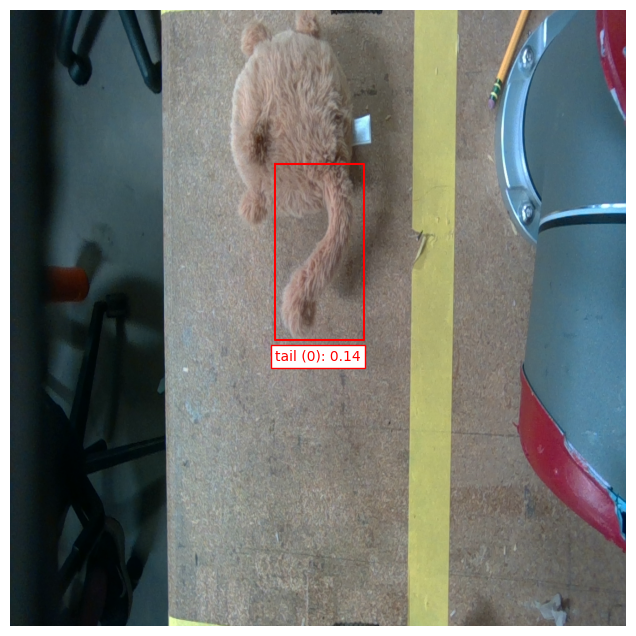

In [97]:
p, rgbd_image = rsc.getPCD()
image = np.array(rgbd_image.color)
queries = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
queries = ["a photo of an blue cylindrical container", "a photo of a small red cubic block", "a photo of a screwdriver handle" ]
queries = ["a photo of a black student ID card", "a photo of a small orange fruit", "a photo of a small plastic bag"]
queries = ["a photo of an avocado", "a photo of a small orange fruit", "a photo of a small plastic bag", "a photo of a paper airplane"]
queries = ["a photo of a water bottle with a red top"]
queries = ["a photo of a tail"]
# queries = ["a photo of a tail"]
# queries = ["a photo of a black handle of a pair of scissors"]
abbrevq = ["apple", "lemon", "lime", "pear", "onion"]
abbrevq = ["blue", "block", "handle"]
abbrevq = ["card", "orange", "bag"]
abbrevq = ["avocado", "orange", "bag", "paper airplane"]
abbrevq = ["tail"]
label_vit.set_threshold(0.105)
bboxes, uboxes = label_vit.label(image, queries, abbrevq, plot=True)


In [98]:
index = 0
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
# rgbd_image, cpcd, tmat = pcd|.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
rgbd_image, cpcd, tmat = pcd.get_segment(label_vit.boxes, 
                                         index, 
                                         rgbd_image, 
                                         rsc, 
                                         type="box-dbscan", 
                                        #  type="box", 
                                        #  method="quat", 
                                         method="iterative", 
                                        #  display=True,
                                         display=False,
                                         viz_scale=1000)
tmat, tmat[:3, 3]

modified indices: [0 1 2]
z-axis dot product: [0.98788471]


(array([[ 1.62301730e-01,  9.83383442e-01,  8.13336017e-02,
         -4.48233730e-02],
        [-9.79695008e-01,  1.50761551e-01,  1.32169003e-01,
         -9.76504066e-04],
        [ 1.17710829e-01, -1.01133381e-01,  9.87884710e-01,
          2.98713496e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([-0.04482337, -0.0009765 ,  0.2987135 ]))

In [99]:
tmat

array([[ 1.62301730e-01,  9.83383442e-01,  8.13336017e-02,
        -4.48233730e-02],
       [-9.79695008e-01,  1.50761551e-01,  1.32169003e-01,
        -9.76504066e-04],
       [ 1.17710829e-01, -1.01133381e-01,  9.87884710e-01,
         2.98713496e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [100]:
mobb = cpcd.get_minimal_oriented_bounding_box()
obb = cpcd.get_oriented_bounding_box()
mobb.extent, obb.extent
width = np.min([*mobb.extent[:3], *obb.extent[:3]])
width

0.0437999963760376

In [17]:
# Segmentation Masks
mask_sam.set_image_and_labels(np.array(rgbd_image.color), np.array([np.array(i[0]) for i in label_vit.boxes]), label_vit.labels)

NameError: name 'mask_sam' is not defined

In [31]:
masks = mask_sam.get_masks(label_vit.labels)

In [33]:
# mask_sam.show_all_masks(np.array(rgbd_image.color))

In [41]:
index = 0
rgbd_image, mcpcd, tmat = pcd.get_segment(mask_sam.masks, 
                                          index, 
                                          rgbd_image, 
                                          rsc, 
                                          type="mask", 
                                          viz_scale=2500.0, 
                                          display=True,
                                          method="quat")

[2.89783432e-04 3.02189035e-04 8.93685382e-05]
[[0.72445858 0.         0.         0.        ]
 [0.         0.75547259 0.         0.        ]
 [0.         0.         0.22342135 0.        ]
 [0.         0.         0.         1.        ]]
[[ 0.15715948 -0.39169133 -0.90657531  0.1473904 ]
 [ 0.69602605 -0.60730595  0.38304988 -0.07536984]
 [-0.7006059  -0.69119996  0.17718349  0.19988548]
 [ 0.          0.          0.          1.        ]]
[[ 0.11385553 -0.29591207 -0.20254828  0.1473904 ]
 [ 0.50424205 -0.458803    0.08558152 -0.07536984]
 [-0.50755996 -0.52218262  0.03958657  0.19988548]
 [ 0.          0.          0.          1.        ]]
TriangleMesh with 1134 points and 2240 triangles.
[Open3D INFO] Window window_8 created.


WebVisualizer(window_uid='window_8')

[Open3D INFO] Sending init frames to window_8.


In [42]:
tmat, tmat[:3, 3]

(array([[ 0.15715948, -0.39169133, -0.90657531, -0.07536984],
        [ 0.69602605, -0.60730595,  0.38304988, -0.1473904 ],
        [-0.7006059 , -0.69119996,  0.17718349,  0.19988548],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([-0.07536984, -0.1473904 ,  0.19988548]))

[7443:635][5386] (stun_port.cc:96): Binding request timed out from 192.168.0.x:36333 (enp3s0)
